# Contents
<font color='blue'><a href='#1'>1. Introduction</a> </font> <br>

<font color='blue'><a href='#3'>2. Data Exploration</a> </font> <br>

<font color='blue'><a href='#4'>3. Analysis</a> </font> <br>

<font color='blue'><a href='#5'>4. Discussion</a> </font>

<font size="6"><a id='1'>1. Introduction</a></font>

The dataset includes a subset extracted from Part D Prescriber Data collected in 2017 by the CMS, which tracks prescription data of healthcare providers across the United States. The objective of this study is to explore and briefly analyze the data in the scope of the opioid crisis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

In [2]:
opioids = pd.read_csv('C:/Users/jo2zh/Downloads/opioids/opioids.csv')
overdoses = pd.read_csv('C:/Users/jo2zh/Downloads/opioids/overdoses.csv')
prescribers = pd.read_csv('C:/Users/jo2zh/Downloads/opioids/prescriber-info.csv')


In [3]:
import re
overdoses['Deaths'] = overdoses['Deaths'].apply(lambda x: float(re.sub(',', '', x)))
overdoses['Population'] = overdoses['Population'].apply(lambda x: float(re.sub(',', '', x)))

A preliminary look through the data shows that the values for 'Deaths' and 'Population' in the overdoses set were string values with commas. These were removed and replaced with usable float values. We also check for missing values in all three datasets and as expected (since this data was preprepped for analysis) we find no further issues.

<font size="6"><a id='1'>2. Data Overview</a></font>

In [4]:
overdoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
State         50 non-null object
Population    50 non-null float64
Deaths        50 non-null float64
Abbrev        50 non-null object
dtypes: float64(2), object(2)
memory usage: 1.6+ KB


The overdoses dataset is comprised of a row for all 50 states, with the population and number of deaths caused by opioid overdose.

In [5]:
prescribers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 256 entries, NPI to Opioid.Prescriber
dtypes: int64(252), object(4)
memory usage: 48.8+ MB


The prescribers dataset is a list of healthcare providers from each state, with relevant identifying information and list of drugs prescribed by each provider. 

In [6]:
opioids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
Drug Name       113 non-null object
Generic Name    113 non-null object
dtypes: object(2)
memory usage: 1.8+ KB


The opioids dataset is simply a list of prescribed opioids, providing the drug name and generic name ofe each.

In [7]:
oplist = list(re.sub(r'[-\s]','.',x) for x in opioids.values[:,0])
prescribed = list(set(oplist) & set(prescribers.columns))

print(prescribed)

['OXYCONTIN', 'MORPHINE.SULFATE.ER', 'METHADONE.HCL', 'HYDROCODONE.ACETAMINOPHEN', 'MORPHINE.SULFATE', 'TRAMADOL.HCL', 'OXYCODONE.ACETAMINOPHEN', 'HYDROMORPHONE.HCL', 'FENTANYL', 'ACETAMINOPHEN.CODEINE', 'OXYCODONE.HCL']


In [8]:
print (float(prescribers['Opioid.Prescriber'].sum())*100/prescribers.shape[0],"%")

58.752 %


From our list of prescribers, we find that around 58.8% of providers in this list are opioid prescribers, and that out of the 250 drugs listed per prescriber, eleven are identified as opioids. 

<font size="6"><a id='1'>3. Analysis</a></font>

In [10]:
prescribers['NumOpioids'] = prescribers.apply(lambda x: sum(x[prescribed]),axis=1)
prescribers['NumPrescriptions'] = prescribers.apply(lambda x: sum(x.iloc[5:255]),axis=1)
prescribers['OpiodPrescribedVsPrescriptions'] = prescribers.apply(lambda x: float(x['NumOpioids'])/x['NumPrescriptions'],axis=1)


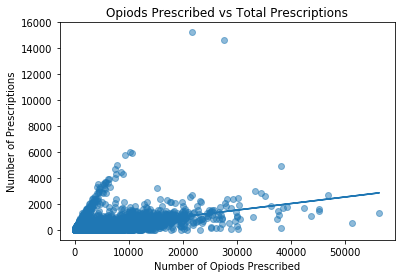

In [11]:
N = prescribers['NumOpioids'].shape[0]
x = prescribers['NumPrescriptions']
y = prescribers['NumOpioids']


plt.scatter(x, y, alpha=0.5)

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, '-')

plt.title('Opiods Prescribed vs Total Prescriptions')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Number of Opioid Prescriptions')
plt.show()

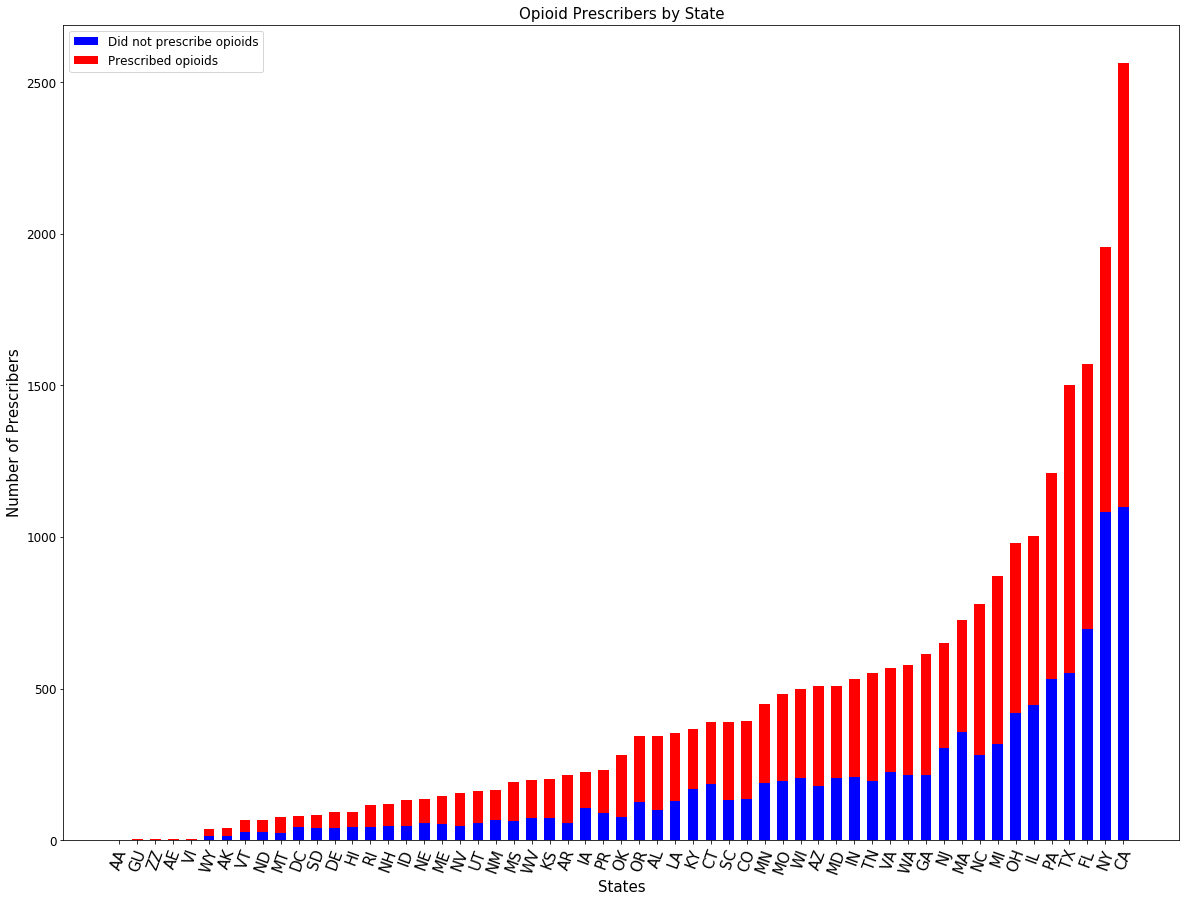

In [12]:
stateCount = pd.DataFrame(prescribers[['State','NPI']].groupby('State').count())

stateCount.reset_index(level=0, inplace=True)

stateCount.columns = ['State', 'Total_Prescribers']

stateCount_PrescribedOpiods = pd.DataFrame(prescribers.loc[prescribers['Opioid.Prescriber']>0,['State','NPI']].groupby('State').count())
stateCount_PrescribedOpiods.reset_index(level=0, inplace=True)
stateCount_PrescribedOpiods.columns = ['State', 'Opiod_Prescribers']
stateCount = pd.merge(stateCount, stateCount_PrescribedOpiods,  how='left', on="State")

stateCount = stateCount.fillna(0)

stateCount = stateCount.sort_values('Total_Prescribers')

fig = plt.gcf()
fig.set_size_inches( 20, 15)

N = stateCount.shape[0]
ind = np.arange(N)
width = 0.6

p1 = plt.bar(ind, stateCount['Total_Prescribers']-stateCount['Opiod_Prescribers'], width, color='b')
p2 = plt.bar(ind, stateCount['Opiod_Prescribers'], width, bottom=stateCount['Total_Prescribers']-stateCount['Opiod_Prescribers'], color='r')

# plt.ylim([0,120])
plt.yticks(fontsize=12)
plt.ylabel("Number of Prescribers", fontsize=15)
plt.xticks(ind,stateCount['State'], fontsize=15, rotation=70)
plt.xlabel('States', fontsize=15)
plt.title("Opioid Prescribers by State", fontsize=15)
plt.legend([p1[0], p2[0]], ["Did not prescribe opioids","Prescribed opioids"], fontsize=12, fancybox=True)
plt.show()

A plot of opioid subscription vs drug subscription indicates that a rise in overall drug prescription disproportionately impacts rise in opioid prescription. By graphing all prescriptions by state we see CA, NY, FL, TX have higher opioid prescribers. These correspond to higher overdose deaths in the overdoses dataset.

<font size="6"><a id='1'>4. Discussion</a></font>

A preliminary look at this data seems to indicate that there is indeed some existing problems with opioids in the United States. However, there can be much more analysis conducted here. For this specific subset of data, we can apply models to try to predict opioid prescription based on overall presciptions using methods like PCA or log regression.
Going even further, we can look at a bigger subset of the entire dataset, namely pulling data from multiple years to study a trend in opioid prescription. This particular subset was from 2017, while the full datset has records going back to 2013.